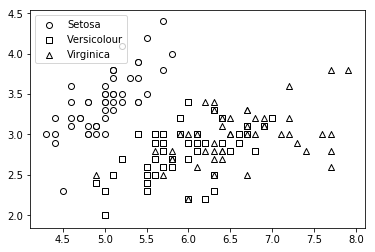

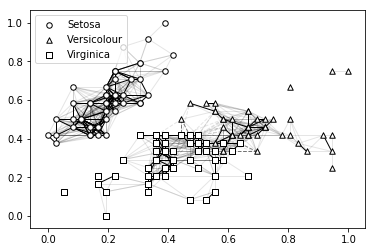

0.7188791219259303


In [18]:
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn import datasets
from sklearn.externals import joblib
from mpl_toolkits.mplot3d import Axes3D
from numpy import *

class Spectrum: 
    def __init__(self,data, n_cluster, gamma=1/np.sqrt(2)):
        self.n_cluster = n_cluster
        self.gamma = gamma
        self.W = None #相似度矩阵
        self.L = None #拉普拉斯矩阵
        self.D = None #度数矩阵
        self.data = data
        
    #预处理     
    def normalization(self): 
        scaler = MinMaxScaler( )
        scaler.fit(self.data)
        scaler.data_max_
        my_matrix_normorlize=scaler.transform(self.data)
        return my_matrix_normorlize   
    
    #欧氏距离
    def ou_dis(self,v1, v2):
        e = np.linalg.norm(np.array(v1) - np.array(v2))
        return 1/(1+e**.5) 
    
    #构建相似矩阵
    def calEuclidDistanceMatrix(self):
        Data = self.data
        N = len(self.data)
        self.W = np.zeros((N, N))
        for i in range(N):
            for j in range(i,N):
                self.W[j][i] = self.W[i][j] = np.exp(-np.sum(np.square(self.data[i] - self.data[j])) / (2 * pow(self.gamma, 2))) #高斯核函数
        a = np.ones(150)
        b = diag(a) 
        self.W = self.W - b #W矩阵对角线元素为零
    
    #标准化的L
    def calLaplacianMatrix(self,adjacentMatrix):

        # compute the Degree Matrix: D=sum(A)
        degreeMatrix = np.sum(adjacentMatrix, axis=1)

        # compute the Laplacian Matrix: L=D-A
        laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix
        #print(laplacianMatrix)
        # normailze
        # D^(-1/2) L D^(-1/2)
        sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
        return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)
    
    #从拉普拉斯矩阵获得特征矩阵   
    def getEigVec(self,L):   
        #L = self.L
        n_cluster= self.n_cluster
        eigval,eigvec = np.linalg.eig(L)
        dim = len(eigval)
        dictEigval = dict(zip(eigval,range(0,dim)))
        kEig = np.sort(eigval)[0:n_cluster]
        ix = [dictEigval[k] for k in kEig]
        return eigval[ix],eigvec[:,ix]
    
    #画原始数据集
    def Draw1(self):
        x = self.data
        x1 = x[:,0]
        x2 = x[:,1]
        plt.scatter(x1[:50],x2[:50], c = "w", edgecolors = 'black',marker='o', label='Setosa') 
        plt.scatter(x1[50:100],x2[50:100], c = "w", marker='s',edgecolors = 'black', label='Versicolour') 
        plt.scatter(x1[100:],x2[100:], c = "w", marker='^', edgecolors = 'black', label='Virginica') 
        plt.legend(loc=2)  
        plt.show()  
    
    #画谱聚类后的数据集 
    def Draw(self,data, y):
        x = data
        x1, x2 = x[:,0], x[:,1]
        G = nx.house_graph()
        # explicitly set positions
        pos = {}
        for i in range(0, 150):
            pos[i] = (x1[i],x2[i])
        nodelists1,  nodelists2,  nodelists3 = [],[],[] #三类样本三个节点列表
        for i in range(0, 150):
            if y[i]==0:
                nodelists1.append(i)
            elif y[i]==1:
                nodelists2.append(i)
            else:
                nodelists3.append(i)
        edglist1, edglist2, edglist3, edglist4 = [], [], [], []  #四种边列表
        dist = np.zeros([150,150])
        for i in range(0,150):
            for j in range(i,150):
                if i!=j:
                    dist[i][j] = dist[j][i] = self.ou_dis(x[i],x[j])               
                    if y[i]==y[j]:
                        if dist[i][j]>0.76: #同一类样本相似度大于0.76则两节点间有一条线
                            edglist1.append((i, j))
                        elif dist[i][j]>0.7:
                            edglist2.append((i, j))
                    else:
                        if dist[i][j]>0.76:
                            edglist3.append((i, j))
                        elif dist[i][j]>0.7:
                            edglist4.append((i, j))
                        
        #设置节点，样式    
        nx.draw_networkx_nodes(G,pos, node_size=30,nodelist=nodelists1, node_color="w", edgecolors="black", node_shape='o',label= 'Setosa')
        nx.draw_networkx_nodes(G,pos, node_size=30,nodelist=nodelists2, node_color="w", edgecolors="black", node_shape='^', label='Versicolour')
        nx.draw_networkx_nodes(G,pos, node_size=30,nodelist=nodelists3, node_color="w", edgecolors="black",node_shape='s',label='Virginica')
        #设置边，样式
        nx.draw_networkx_edges(G,pos,edgelist=edglist1 )
        nx.draw_networkx_edges(G,pos,edgelist=edglist2, alpha=0.1)
        nx.draw_networkx_edges(G,pos,edgelist=edglist3, alpha=0.5, style='dashed')
        nx.draw_networkx_edges(G,pos,edgelist=edglist4, alpha=0.1, style='dashed')
        plt.legend(loc=2) 
        plt.axis('on')
        plt.show()
        

if __name__ == '__main__':
    #导入鸢尾花的数据集
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.cluster import KMeans
    from sklearn import metrics
    import numpy as np
    from sklearn import datasets
 
    
    np.random.seed(0)
    iris = datasets.load_iris()
    iris_x = iris.data
    iris_y = iris.target  
  
    sp = Spectrum(iris_x, 3, 1.0)   #构造Spectrum类
    sp.Draw1()
    sp.data = sp.normalization() #数据集标准化
    sp.calEuclidDistanceMatrix() #相似矩阵
    L = sp.calLaplacianMatrix(sp.W) #标准化的L
    x, V = sp.getEigVec(L) #求L的特征值和特征向量
    #indices = np.random.permutation(len(sp.data))
    clf = KMeans(n_clusters=3,algorithm='auto')
    label_pred = clf.fit_predict(V) #label_pred = clf.labels_ 相同效果
    #sp.Draw(sp.data, label_pred)
    sp.Draw(sp.data, label_pred)
    #print(clf.cluster_centers_)
    #正确率评价指标--FMI，
    print(metrics.fowlkes_mallows_score(iris_y, label_pred))
    #sp_kmeans = KMeans(n_clusters=3).fit(V)
    #pure_kmeans = KMeans(n_clusters=3).fit(sp.data)

    

Done
5


{0: [array([0.22222222, 0.625     , 0.06779661, 0.04166667]),
  array([0.16666667, 0.41666667, 0.06779661, 0.04166667]),
  array([0.11111111, 0.5       , 0.05084746, 0.04166667]),
  array([0.08333333, 0.45833333, 0.08474576, 0.04166667]),
  array([0.19444444, 0.66666667, 0.06779661, 0.04166667]),
  array([0.30555556, 0.79166667, 0.11864407, 0.125     ]),
  array([0.08333333, 0.58333333, 0.06779661, 0.08333333]),
  array([0.19444444, 0.58333333, 0.08474576, 0.04166667]),
  array([0.02777778, 0.375     , 0.06779661, 0.04166667]),
  array([0.16666667, 0.45833333, 0.08474576, 0.        ]),
  array([0.30555556, 0.70833333, 0.08474576, 0.04166667]),
  array([0.13888889, 0.58333333, 0.10169492, 0.04166667]),
  array([0.13888889, 0.41666667, 0.06779661, 0.        ]),
  array([0.        , 0.41666667, 0.01694915, 0.        ]),
  array([0.41666667, 0.83333333, 0.03389831, 0.04166667]),
  array([0.38888889, 1.        , 0.08474576, 0.125     ]),
  array([0.30555556, 0.79166667, 0.05084746, 0.125   

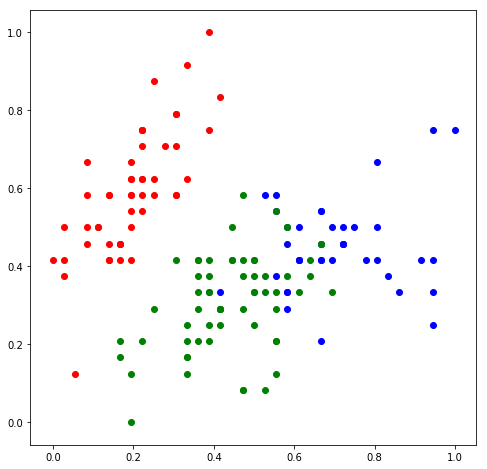

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

def Distance(x):
    def Dis(y):
        return np.sqrt(sum((x-y)**2))                      #欧式距离
    return Dis

def init_k_means(k):
    k_means = {}
    for i in range(k):
        k_means[i] = []
    return k_means

def cal_seed(k_mean):                                      #重新计算种子点
    k_mean = np.array(k_mean)
    new_seed = np.mean(k_mean,axis=0)                      #各维度均值
    return new_seed
    
def K_means(data,seed_k,k_means):
    for i in data:
        f = Distance(i)
        dis = list(map(f,seed_k))                        #某一点距所有种子点的距离
        index = dis.index(min(dis))
        k_means[index].append(i)
    
    new_seed = []                                           #存储新种子
    for i in range(len(seed_k)):
        new_seed.append(cal_seed(k_means[i]))
    new_seed = np.array(new_seed)
    return k_means,new_seed
    
def run_K_means(data,k):
    seed_k = data[random.randint(len(data),size=k)]       #随机产生种子点
    k_means = init_k_means(k)                                #初始化每一类
    result = K_means(data,seed_k,k_means)
    count = 0
    while not (result[1] == seed_k).all():                     #种子点改变，继续聚类
        count+=1
        seed_k = result[1]
        k_means = init_k_means(k)   
        result = K_means(data,seed_k,k_means)
    print('Done')
    #print(result[1])
    print(count)
    plt.figure(figsize=(8,8))
    Color = 'rbgyckm'
    for i in range(k):
        mydata = np.array(result[0][i])
        plt.scatter(mydata[:,0],mydata[:,1],color = Color[i])
    return result[0]
from sklearn import datasets
iris = datasets.load_iris()
iris_x = iris.data
iris_y = iris.target
#data = np.loadtxt('K-means_data')
run_K_means(sp.data,k=3)


0.8112427991975698


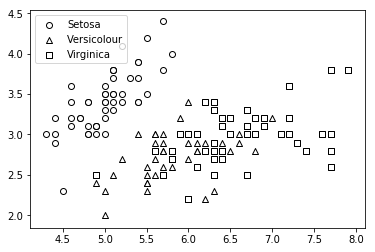

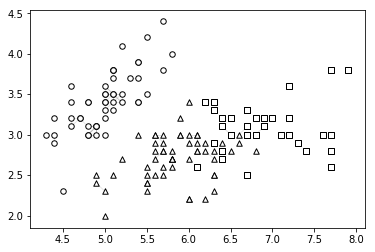